In [2]:
import utils, shapely_utils as shu, python_utils as pu, cairo_utils as cu, plotter_utils as plu
import bezier
import numpy as  np
from shapely import LineString, MultiLineString, GeometryCollection
import shapely as sh

In [3]:
# imports
from pathlib import Path, PurePath
import sys

In [4]:
def morse_code(to_morse):
    char_to_morse = {
        'a': '.-',
        'b': '-...',
        'c': '-.-.',
        'd': '-..',
        'e': '.',
        'f': '..-.',
        'g': '--.',
        'h': '....',
        'i': '..',
        'j': '.---',
        'k': '-.-',
        'l': '.-..',
        'm': '--',
        'n': '-.',
        'o': '---',
        'p': '.--.',
        'q': '--.-',
        'r': '.-.',
        's': '...',
        't': '-',
        'u': '..-',
        'v': '...-',
        'w': '.--',
        'x': '-..-',
        'y': '-.--',
        'z': '--..'
    }
    return " ".join([char_to_morse[c.lower()] for c in to_morse])

In [ ]:
# line = LineString([[0,0],[1,1]])

In [6]:
def morse_to_line(line, morse_word, n_characters, circle_proportion=0.6, segment_proportion=0.8, space_proportion=0.6):
    segs  = shu.geoms(shu.segmentize(line, n_characters))
    # return shu.printg(*segs)
    all_segs = []
    for i in range(n_characters):
        seg = segs[i]
        char = morse_word[i%len(morse_word)]
        if (char=='.'):
            all_segs.append(shu.Circle(seg.centroid,seg.length*circle_proportion/2))
        elif (char=='-'):
            seg_f = sh.affinity.scale(seg, segment_proportion, segment_proportion)
            all_segs.append(seg_f)
        elif (char==" "):
            seg_f = sh.affinity.scale(seg, space_proportion, space_proportion)
            seg_f = sh.affinity.rotate(seg_f, 90,)
            all_segs.append(seg_f)
    return shu.printg(*all_segs)

In [7]:
# morse_to_line(sh.LineString([[0,0], [1,1]]), morse_code('pere'), 16)

In [8]:
# morse_code('berta')
# morse_code('pere')

In [9]:
def bball_net(radius,m=0.15,n=0.25,total_slices=12,len_straight=4, prop_h=0.5):
    curve = bezier.Curve(np.asfortranarray(np.matrix([[0,0],[n/4,m],[n,prop_h*m]]).transpose()), degree=2)
    line = LineString([[-n/3,-n/len_straight],[0,0]])
    # return line
    l = sh.line_merge(MultiLineString([line,shu.curve_to_ls(curve)]))
    # return line
    a,b,c,d = l.bounds
    x_dist = c-a
    y_dist = d-b
    w_line,h_line = shu.size(line)
    
    p = sh.line_merge(MultiLineString([l,sh.affinity.translate(sh.affinity.scale(l, -1, 1),x_dist)]))
    # return l
    # return p
    w,h = shu.size(p)
    scale_prop = radius/w
    p = sh.affinity.scale(p, scale_prop, scale_prop)
    p2 = sh.affinity.translate(sh.affinity.scale(p, 1, -1),0,- h * scale_prop + h_line*scale_prop*2)
    lip = GeometryCollection([p,p2])
    # return lip
    # return lip
    # return lip
    tots_lips = []
    mergers_entre_lips = []
    def getLines(last_line, new_line):
        line = LineString([list(list(new_line.geoms)[1].coords)[0],list(list(last_line.geoms)[0].coords)[0]])
        line2 = LineString([list(list(new_line.geoms)[0].coords)[-1],list(list(last_line.geoms)[1].coords)[-1]])
        return [line, line2]
    first_line = None
    for i in range(int(total_slices/2)):
        new_line = sh.affinity.rotate(lip, i*(360/total_slices))
        if (i>0):
            mergers_entre_lips += getLines(last_line, new_line)
        else:
            first_line = new_line
        tots_lips.append(new_line)
        last_line = new_line
    # inverse
    line = LineString([list(list(first_line.geoms)[1].coords)[0],list(list(last_line.geoms)[1].coords)[-1]])
    line2 = LineString([list(list(first_line.geoms)[0].coords)[-1],list(list(last_line.geoms)[0].coords)[0]])
    mergers_entre_lips += [line, line2]
    # return tots_lips
    # print(len(tots_lips))
    # return [tots_lips,mergers_entre_lips]
    return shu.StructuredCollection(lips=tots_lips, lips_mergers=mergers_entre_lips)

In [10]:
def spiral(radius, step, resolution=.1, angle=0.0, start=0.0, middle_point=sh.Point(0,0)):
    import math
    dist = start+0.0
    coords=[]
    while dist*math.hypot(math.cos(angle),math.sin(angle))<radius:
        cord=[]
        cord.append(dist*math.cos(angle))
        cord.append(dist*math.sin(angle))
        coords.append(cord)
        dist+=step
        angle+=resolution

    spiral_shape = LineString(coords)
    v = (middle_point.x-spiral_shape.centroid.x,middle_point.y-spiral_shape.centroid.y)
    return sh.affinity.translate(spiral_shape,  v[0], v[1])

In [11]:
def segmentize_and_rotate(l, num_segments, scale_factor=0.8, max_angle=60, invert=False):
    all_segments = []
    next_scaled_2_shape = None
    # try:  
    for a in shu.geoms(shu.segmentize(l,num_segments)):
        scale_each = scale_factor/2
        if invert:
            scaled_1_shape = shu.sliceCurve(a, 0,scale_each)
            newLine = scaled_1_shape
            if not next_scaled_2_shape is None:
                newLine = shu.LineString((shu.coords(next_scaled_2_shape)+shu.coords(scaled_1_shape)))
                all_segments.append(newLine)
            else:
                all_segments.append(newLine)
            next_scaled_2_shape = shu.sliceCurve(a, 1-scale_each,1)
        else:    
            # final_shape = sh.affinity.scale(a,scale_factor,scale_factor)
            scaled_shape = shu.sliceCurve(a, 0.5-scale_each,0.5+scale_each)
            final_shape = sh.affinity.rotate(scaled_shape,(random.random()-0.5)*(max_angle))
            all_segments.append(final_shape)
    # except Exception as ex:
    #    print(ex)
    if invert:
        all_segments.append(next_scaled_2_shape)
    return shu.printg(*all_segments)

In [12]:
pu.reload(shu)

In [13]:
# upB = bball_net(50, 0.15,0.25,10,3.7,0.85)
# downB = bball_net(50, 0.15,0.25,10,3.7,0.85).translate(0,-100)
# aw.upper_bball = upB.geo
# aw.lower_bball = downB.geo
# downB2 = bball_net(50, 0.15,0.25,12,3.7,0.85).translate(0,90)
# shu.printg([upB.geo, downB.geo])

In [14]:
# TODO: per aixo que vull he de fer que es vagi fent mes petita
# spiral_up = spiral(25, 0.025, start=50/5, middle_point=upB.geo.centroid)
# groups = morse_to_line(spiral_up, morse_code('pere'), 300)
# upB

In [15]:
aw = pu.DotMap()
upB = bball_net(50, 0.15,0.25,10,3.7,0.85)
downB = bball_net(50, 0.15,0.25,10,3.7,0.85).translate(0,-100)
convex_hull_upB = shu.convex_hull(upB.geo, 100, True, 0.5)
convex_hull_downB = shu.convex_hull(downB.geo, 100, True, 0.5)
# spiral_up = create_circles(upB.geo.centroid,step=3, min_radius=50/4.5,max_radius=30)
# spiral_up = shu.printg(*[shu.segmentize(c,35) for c in shu.geoms(spiral_up)])
# spiral_up = shu.printg(*[shu.segmentize_dist(c,3.5) for c in shu.geoms(spiral_up)])
spiral_up = spiral(25, 0.025, start=50/5, middle_point=upB.geo.centroid)
# spiral_up = shu.segmentize(spiral_up,100)
spiral_up = morse_to_line(spiral_up, morse_code('pere'), 300)
magic_polygon_up = shu.printg(*[sh.Polygon(c.coords) for c in list(upB.geo.buffer(0.5).interiors)]).intersection(convex_hull_upB)
spiral_up = spiral_up.intersection(magic_polygon_up)
spiral_down = spiral(25, 0.025, start=50/5, middle_point=downB.geo.centroid)
# spiral_down = shu.segmentize(spiral_down,100)
# spiral_down = create_circles(downB.geo.centroid,step=3, min_radius=50/4.5,max_radius=30)
# spiral_down = shu.printg(*[shu.segmentize(c,35) for c in shu.geoms(spiral_down)])
# spiral_down = shu.printg(*[shu.segmentize_dist(c,3.5) for c in shu.geoms(spiral_down)])
spiral_down = morse_to_line(spiral_down, morse_code('berta'), 300)
magic_polygon_down = shu.printg(*[sh.Polygon(c.coords) for c in list(downB.geo.buffer(0.5).interiors)]).intersection(convex_hull_downB)
spiral_down = spiral_down.intersection(magic_polygon_down)
aw.upper_bball = upB.geo
aw.lower_bball = downB.geo
aw.spiral_up = spiral_up
aw.spiral_down = spiral_down
# downB2 = bball_net(50, 0.15,0.25,12,3.7,0.85).translate(0,90)
# shu.printg([upB.geo, downB.geo])

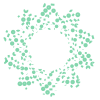

In [16]:
spiral_up

In [17]:
# shu.printg(upB.geo, aw.spiral_up, *guides)


In [18]:
first_item = None
guides = []
top_mergers = 5
top_mergers_up = shu.reorder_geos(shu.geoms(upB['lips_mergers']), "S", top_mergers)
# estirals explotals TODO
scale_factor = 2
# top_mergers_up = [sh.affinity.scale(sh.affinity.translate(m,0,-6),scale_factor) for m in top_mergers_up]
top_mergers_down = shu.reorder_geos(shu.geoms(downB['lips_mergers']), "N", top_mergers)
# top_mergers_down = [sh.affinity.scale(sh.affinity.translate(m,0,6),scale_factor) for m in top_mergers_down]
for i,springs in enumerate(zip(shu.reorder_geos(top_mergers_up, "E"), shu.reorder_geos(top_mergers_down, "E"))):
    s1, s2 = springs
    # if (not last is None):
    guides.append(LineString([shu.first(s1), shu.last(s2)]))
    guides.append(LineString([shu.last(s1), shu.first(s2)]))
    # last = shu.last(s2)
force_middle = 0.5
force_second = 0.72
field = [0,0,force_second, force_second,force_middle,force_middle,force_second, force_second,0,0]
guides = [shu.deform_line(g, GeometryCollection(guides).centroid, 0.3+field[i]*0.2) for i,g in enumerate(guides)]

In [19]:
# pu.reload(shu)

In [20]:
# shu.printg(*guides)

In [21]:
# force_y = shu.create_peak_function(5)
# [shu.gaussian_generator(x_max=2)(i)**0.08 for i in range(5)]

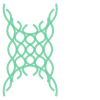

In [22]:
import random
random.seed(10)
curves = []
trenes = []
# right_lines = []
force_y = lambda x: shu.gaussian_generator(x_max=2)(i)**0.5
for j,g in enumerate(pu.chunk_list(guides,2)):
    extra_force = 0
    
    trena = []
    # print(i)
    other_guide = g[0]
    guide = g[1]
    if g[0].length>g[1].length:
        guide = g[0]
        other_guide = g[1]
    segments = shu.segmentize(guide, 5).geoms
    other_segments = shu.segmentize(other_guide, 5).geoms
    initial_coords = [shu.first(g[0]),shu.first(g[1])]
    last = None
    last_coords = [shu.last(g[0]),shu.last(g[1])]
    # print(len(segments))
    for i in range(len(segments)):
        extra_force = 0
        if j == 2:
            if i==0 or i==4:
                extra_force = 3.25
            if i==1 or i==3:
                extra_force = 1
        if j==1 or j==3:
            if i==1 or i==3:
                extra_force = 1.5
        segment = segments[i]
        other_segment = other_segments[i]
        total = 2+force_y(j)*2+extra_force
        curves_el = None
        
        if (i==0):
            initial_coords = shu.reorder_geos([sh.Point(v) for v in initial_coords], "O")
            centroid_segments = LineString([shu.last(segment),shu.last(other_segment)]).centroid
            curves_el = shu.create_ellipse(initial_coords[0],centroid_segments, total, initial_coords[1], num_points=50)
            curves += curves_el
            last = centroid_segments
        elif (i==len(segments)-1):
            centroid_segments = LineString([shu.first(segment),shu.first(other_segment)]).centroid
            last_coords = shu.reorder_geos([sh.Point(v) for v in last_coords], "E")
            curves_el = shu.create_ellipse(last_coords[0], centroid_segments, total, last_coords[1], num_points=50)
            curves += curves_el
        else:
            centroid_segments = LineString([shu.last(segment),shu.last(other_segment)]).centroid
            curves_el = shu.create_ellipse(last, centroid_segments, total, num_points=50)
            curves += curves_el
            last = centroid_segments
        
        lines_in_between = 5
        
        trena.append(curves_el)
    trenes.append(trena)
        
shu.printg(*pu.flat(trenes),)  


In [23]:
# len(trenes[0][0][0].coords)

In [24]:

# TODO la del mig esta torta!

In [25]:
# trenes
# scale_factor_lines = 1.2

In [26]:
# translate_lines = 25

In [27]:
up_line = sh.affinity.scale(LineString([shu.first(trenes[0][0][1]),shu.first(trenes[-1][0][0])]),1,1,0)
# up_line = sh.affinity.translate(up_line,0,translate_lines)
half_middle_upper = LineString([shu.first(trenes[2][0][1]),shu.first(trenes[2][0][0])])
curved_up = shu.curved_path(shu.first(up_line),shu.last(up_line),half_middle_upper.centroid)
# curved_up = sh.affinity.translate(curved_up, 0, -8)
# shu.printg(*([up_line,half_middle_upper]+curves))

In [28]:
down_line = sh.affinity.scale(LineString([shu.first(trenes[0][-1][0]),shu.first(trenes[-1][-1][1])]),1,1,0)
# down_line = sh.affinity.translate(down_line,0,-translate_lines)
half_middle_down= LineString([shu.first(trenes[2][-1][0]),shu.first(trenes[2][-1][1])])
# shu.printg(*([down_line,half_middle_down]+curves))
curved_down = shu.curved_path(shu.first(down_line),shu.last(down_line),half_middle_down.centroid)
# curved_down = sh.affinity.translate(curved_down, 0, 8)

In [29]:
translate_distance = sh.distance(half_middle_down,half_middle_upper)

In [30]:
w_c_up,h_c_up = shu.size(curved_up)

In [31]:
midpoint = sh.shortest_line(curved_up,curved_down).centroid
until_point_down = sh.Point(midpoint.x, midpoint.y+h_c_up)
until_point_up = sh.Point(midpoint.x, midpoint.y-h_c_up)

In [32]:
# shu.printg(curved_down, until_point_down)

In [33]:
w,h = shu.size(curved_down)
less_x_midpoint = sh.Point(midpoint.x-w/2, midpoint.y)
more_x_midpoint = sh.Point(midpoint.x+w/2, midpoint.y)
# # more_x_midpoint = shu.copy(midpoint)
# # less_x_midpoint.x += w/2
middle_line = LineString([more_x_midpoint,less_x_midpoint])
# # midpoint.x -= w/2

In [34]:
# shu.printg(*all_lines)

In [35]:
def morph_from_line_to_other(line1, line2, n_steps, n_points):
    n_points_line_1 = shu.distribute_points(line1, n_points)
    n_points_line_2 = shu.distribute_points(line2, n_points)
    matrix_points = np.matrix([shu.distribute_points(LineString([n_points_line_1[i],n_points_line_2[i]]), n_steps) for i in range(n_points)])
    all_lines = []
    for col in matrix_points.T:
        line = sh.LineString(np.squeeze(np.asarray(col)))
        all_lines.append(line)
    return all_lines

In [36]:
def morph_several( n_steps, n_points, *args,):
    total_lines = []
    for a,b in pu.iter_two(args):
        total_lines += morph_from_line_to_other(a,b,n_steps, n_points)
    return total_lines

In [37]:
# list(force_iterator(shu.geoms(waves_up), force_lines, ))
# waves_up

In [38]:
pu.reload(shu)

In [39]:
# force_lines = shu.linear_generator(x_max=len(accordion_up))
# for u,f in shu.force_iterator(accordion_up, force_lines):
#     shu.segmentize(u,10+30*f)

In [40]:
# 10+30*f

In [41]:
# force_lines = shu.linear_generator(x_max=int(len(accordion_up)))
# waves_up = shu.printg(*[segmentize_and_rotate(u,20,0.9,0) for u,f in shu.force_iterator(accordion_up, force_lines)])
# waves_down = shu.printg(*[segmentize_and_rotate(u,30,0.8,0) for u,f in shu.force_iterator(accordion_down, force_lines)])

In [42]:

# Example usage:
# my_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
pu.reload(pu)
# print(split_randomly_equal(my_list, 3))

In [43]:
number_lines = 30
waves_up = shu.printg(*shu.repeat_geometry_along_path(curved_up,sh.shortest_line(curved_up,sh.Point(until_point_up)),number_lines))
waves_down = shu.printg(*shu.repeat_geometry_along_path(curved_down,sh.shortest_line(curved_down,sh.Point(until_point_down)),number_lines))
waves_up = shu.printg(*shu.geoms(waves_up)[2:])
waves_down = shu.printg(*shu.geoms(waves_down)[2:])
# waves_up = sh.affinity.translate(waves_up,0,0.4)
force_lines = shu.linear_generator(x_max=int(number_lines))
waves_up = shu.printg(*[segmentize_and_rotate(u,10+30*f,0.8,0) for u,f in shu.force_iterator(shu.geoms(waves_up), force_lines)])
waves_down = shu.printg(*[segmentize_and_rotate(u,10+30*f,0.8,0,) for u,f in shu.force_iterator(shu.geoms(waves_down), force_lines)])

too small 0.0015625000000000222
too small 0.002857142857142836
too small 0.003947368421052644
too small 0.004878048780487809
too small 0.005681818181818177
too small 0.0063829787234042645
too small 0.006999999999999951
too small 0.0075471698113206975
too small 0.008035714285714257
too small 0.008474576271186474
too small 0.00887096774193552
too small 0.009230769230769265
too small 0.009558823529411842
too small 0.009859154929577452
too small 0.0015625000000000222
too small 0.002857142857142836
too small 0.003947368421052644
too small 0.004878048780487809
too small 0.005681818181818177
too small 0.0063829787234042645
too small 0.006999999999999951
too small 0.0075471698113206975
too small 0.008035714285714257
too small 0.008474576271186474
too small 0.00887096774193552
too small 0.009230769230769265
too small 0.009558823529411842
too small 0.009859154929577452


In [44]:
# waves_up.intersection(sh.Polygon(shu.Circle(upB.geo.centroid, shu.size(upB.geo)[0]/2)))
waves_up

In [45]:
waves_up = waves_up.difference(sh.Polygon(shu.Circle(upB.geo.centroid,25)))
waves_down = waves_down.difference(sh.Polygon(shu.Circle(downB.geo.centroid, 25)))

In [46]:
# shu.printg(shu.printg(*shu.geoms(waves_down)[:-2]),shu.printg(*shu.geoms(waves_up)[:-2]))
# waves_up

In [47]:
# shu.printg(shu.printg(*shu.geoms(waves_down)[2:]),)

In [48]:
from shapely.ops import split
waves_up = sh.intersection(shu.geoms(split(waves_up.convex_hull, middle_line))[1],waves_up)
waves_down = sh.intersection(shu.geoms(split(waves_down.convex_hull, middle_line))[0],waves_down)

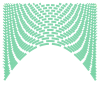

In [49]:
waves_down

In [50]:
# shu.convex_hull(waves_down)
# shu.Polygon(shu.line_merge(boundary).buffer(0.1).interiors)

In [51]:
# shu.printg(shu.line_merge(boundary).buffer(1), shu.line_merge(boundary).buffer(0.1))

In [52]:
all_polygons = []
all_cs = []
i = 0
for t in trenes:
    for cs in t:
        c1,c2=cs
        boundary = [c1.reverse(), c2]
        all_cs.append(boundary)
        polygon = sh.Polygon(*shu.line_merge(boundary).buffer(0.5).interiors)
        if not polygon.is_simple:
            print('bad',i)
            # break
        all_polygons.append(polygon)
        i+=1
intersected_up_in = []
intersected_up_out = []

for line in shu.geoms(waves_up):
  remaining_line = shu.copy(line)
  for i,p in enumerate(all_polygons):
    try:
      intersection = sh.intersection(p, line)
      remaining_line = sh.difference(remaining_line, p)
      if not intersection.is_empty:
        intersected_up_in.append(intersection)
    except:
      print('error',i) 
  if not remaining_line.is_empty:
    intersected_up_out.append(remaining_line)
intersected_down_in = []
intersected_down_out = []
for line in shu.geoms(waves_down):
  remaining_line = shu.copy(line)
  for i,p in enumerate(all_polygons):
      try:
        intersection = sh.intersection(p, line)
        remaining_line = sh.difference(remaining_line, p)
        if not intersection.is_empty:
          intersected_down_in.append(intersection)
      except:
        print('error',i) 
  if not remaining_line.is_empty:
    intersected_down_out.append(remaining_line)

In [53]:
# intersected_down_out
# started

In [54]:
# intersected_down_in

In [55]:
# remaining_line = shu.copy(line)
#   possible_additions = []
#   for i,p in enumerate(all_polygons):
#       try:
#         intersection = sh.intersection(p, line)
#         remaining_line = sh.difference(remaining_line, p)
#         if not intersection.is_empty:
#           intersected_down_in.append(intersection)
#       except:
#         print('error',i) 
#   if not remaining_line.is_empty:
#     if remaining_line.length/line.length>0.5:
#       intersected_down_out.append(line)
#     else:
#       intersected_down_in.append(line)

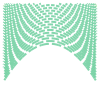

In [56]:
# shu.geoms(waves_down)[56]
shu.printg(*(intersected_down_out+intersected_down_in))

In [57]:
# shu.printg(*(intersected_up_in+trenes))

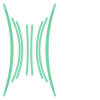

In [58]:
shu.printg(*guides)

In [59]:
concave_hull_guides = sh.concave_hull(shu.printg(*guides),ratio=0.1)
aw.intersected_up_in=intersected_up_in
aw.intersected_up_out=sh.intersection(concave_hull_guides,shu.printg(*intersected_up_out))
aw.intersected_down_out=sh.intersection(concave_hull_guides,shu.printg(*intersected_down_out))
aw.intersected_down_in=intersected_down_in

In [60]:
def intersected_geoms(primaryGeo, secondGeo):
    for g in shu.geoms(primaryGeo):
        if g.intersects(secondGeo):
            yield g

In [61]:
# aw.intersected_up_1,aw.intersected_up_2,aw.intersected_up_3,aw.intersected_up_4 = pu.split_randomly(shu.flatten(intersected_up),4)
# aw.intersected_down_1,aw.intersected_down_2,aw.intersected_down_3,aw.intersected_down_4 = pu.split_randomly(shu.flatten(intersected_down),4)

In [62]:
upB_lips_mergers = shu.reorder_geos(shu.geoms(upB['lips_mergers']), "N", top_mergers)
downB_lips_mergers = shu.reorder_geos(shu.geoms(downB['lips_mergers']), "S", top_mergers)
upB['lips_mergers'] = shu.printg(*upB_lips_mergers)
downB['lips_mergers'] = shu.printg(*downB_lips_mergers)
aw.upper_bball = upB.geo
aw.lower_bball = downB.geo

In [63]:
aw.trenes = shu.printg(*pu.flat(trenes))

In [64]:
def random_point(line):
    import random
    return line.interpolate(random.random()*line.length)

In [65]:
def point_outside_line(line, positive,at=0.5):
    coords = shu.coords(line)
    a,b = coords[0],coords[-1]
    line_ab = LineString([a,b])
    point = line_ab.interpolate(line_ab.length*at)
    v= shu.diff(a,b)
    xv,yv = shu.normal_vector(v)
    return [point.x + positive*line_ab.length*xv, point.y + positive*line_ab.length*yv]

In [66]:
def create_curve_line(line, positive, at=0.5):
    coords = shu.coords(line)
    a,b = coords[0],coords[-1]
    c = point_outside_line(line, positive, at)
    return shu.curved_path(a,b,c)

In [67]:
first_point = curved_down.interpolate(0.05*curved_down.length)
mid_point_first = middle_line.interpolate(0.95*middle_line.length)
mid_point_second = middle_line.interpolate(0.05*middle_line.length)
second_point = curved_up.interpolate(0.95*curved_up.length)
linies_width = 2.5
line_down = create_curve_line(LineString([first_point, mid_point_first]),-0.08,0.1).buffer(linies_width)
line_up =  create_curve_line(LineString([second_point, mid_point_second]),-0.08,0.1).buffer(linies_width)

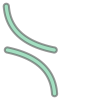

In [68]:
shu.printg(line_down,line_up)

In [69]:
intersected_up_in_inline = [] 
intersected_up_in_outline = [] 
for line in intersected_up_in:
    remaining_line = shu.copy(line)
#   for i,p in enumerate(all_polygons):
    p = line_up
    try:
        intersection = sh.intersection(p, line)
        remaining_line = sh.difference(remaining_line, p)

        # if not intersection.is_empty:
        if intersection.length/line.length>0.5:
            intersected_up_in_inline.append(line)
        # if not remaining_line.is_empty:
        else:
            intersected_up_in_outline.append(line)
    except:
        print('error',i) 

In [70]:
intersected_down_in_inline = [] 
intersected_down_in_outline = [] 
for line in intersected_down_in:
    remaining_line = shu.copy(line)
#   for i,p in enumerate(all_polygons):
    p = line_down
    try:
        intersection = sh.intersection(p, line)
        remaining_line = sh.difference(remaining_line, p)
        if intersection.length/line.length>0.5:
            intersected_down_in_inline.append(intersection)
        # if not remaining_line.is_empty:
        else:
            intersected_down_in_outline.append(remaining_line)
    except:
        print('error',i) 

In [71]:
# intersected_down_in_inline
# aw.intersected_down_out = intersected_down_out
# aw.intersected_up_out = intersected_up_out
aw.intersected_down_in_outline = intersected_down_in_outline
aw.intersected_down_in_inline = intersected_down_in_inline
aw.intersected_up_in_outline = intersected_up_in_outline
aw.intersected_up_in_inline = intersected_up_in_inline

In [72]:
# shu.printg(curved_up, middle_line, curved_down,line_down, line_up)

In [73]:
# waves_up
# aw.intersected_down_in_outline
# aw.intersected_down_in_inline

In [75]:
pu.reload(cu)

In [76]:
cu.create_artwork(aw, colored, 0.2,0.1, 'svg')

In [77]:
pu.reload(shu)

In [78]:
print(1)

1


In [79]:
# shu.size(collection.geo)

(5.12974618479674, 15.075635365912262)

In [81]:
# (colors.index("c")+1)/(len(colors)+1)

In [82]:
# shu.printg(curve, curve.interpolate(0.85))

In [83]:
def get_signature_geo(color, colors, calibration_point, length=0.5, length_arc=0.25):
    curve = shu.sliceCurve(shu.Circle(calibration_point, length+length_arc), 0.75,1)
    p = curve.interpolate(curve.length*(colors.index(color)+1)/(len(colors)+1))
    a = [calibration_point[0],calibration_point[1]]
    b = [calibration_point[0],calibration_point[1]+length]
    c = [calibration_point[0]-length,calibration_point[1]]
    return sh.LineString([b,a,c,p,b])

In [84]:
def alignment_manouver(plotter, calibration_point, color, colors, firma=False):
    
    val = input("prepare and protect change to "+ color+ "State: pendown")
    plotter.penup()
    val = input("Press anykey to start manouvre "+ color+ "Following: Signature")
    delta = [0,0]
    # plotter.moveto(*calibration_point)
    while (val!="ok"):
        plotter.penup()
        plotter.moveto(calibration_point[0]+delta[0],calibration_point[1]+delta[1])
        plotter.pendown()
        val = input("Is it ok? (yes == '' / no)")
        plotter.penup()
        # if val in ["up", "down"]:
        #     while (val in ["up", "down"]):
        #         if val == "up":
        #             plotter.penup()
        #         if val == "down":
        #             plotter.pendown()
        #         val = input("Is it ok? (up, down, ok, '', no)")
        if val == "ok" or val=="":
            break
        elif val == "quit":
            return None
        x_y = val.split(",")
        if len(x_y)>1:
            x,y=x_y
            delta[0]+=float(x)/10
            delta[1]+=float(y)/10
        
    if firma:
        pass
        # geometry = get_signature_geo(color, colors, (calibration_point[0]+delta[0],calibration_point[1]+delta[1]))#shu.Rect((calibration_point[0]+delta[0],calibration_point[1]+delta[1]),1,1.5)
        # plu.plot(plotter, geometry)
    return delta

In [85]:
prova = {
    "layer1":shu.Rect((10,10),1.5,1.5),
    "layer2":shu.Circle((10,10), 1.5),
    "layer3":shu.Rect((10,10), 1.5,1.5),
    "layer4":shu.Circle((10,10), 1.5)
}
colored_prova = {
    "layer1":"red",
    "layer2":"blue",
    "layer3":"red",
    "layer4":"blue"
}

In [86]:
def create_artwork(plotter, aw, colored_, x_margin=2,y_margin=2, calibration_point=(20,20)):
    colored = colored_
    geo = shu.printg(*pu.flat(aw.values()))
    xmin,ymin,xmax,ymax = geo.bounds
    xmin = min(xmin,0)
    ymin = min(ymin,0)
    extra_x = abs(xmin)
    extra_y = abs(ymin)
    # geo = sh.affinity.translate(geo, , abs(ymin))
    # xmin,ymin,xmax,ymax = geo.bounds
    # geo_width,geo_height  = (abs(xmax-xmin),abs(ymax-ymin))
    geo_width,geo_height = shu.size(geo)
    x_margin_total = x_margin
    y_margin_total = y_margin
    marc_width = geo_width+2*x_margin_total
    marc_height = geo_height+2*y_margin_total
    last_color = ''
    discovered_colors = []
    for color_k,color in colored.items():
        if color_k == 'background':
            continue
        print('plotting', color_k)
        val = None
        if color != last_color:
            firma = not color in discovered_colors
            val = alignment_manouver(plotter, calibration_point, color, list(set(colored.values())),firma = firma)
            if firma:
                discovered_colors.append(color)
            plotter.penup()
        if val is None:
            print('breaking', color_k)
            break
        geo_item = aw[color_k]
        if pu.iterable(geo_item):
            geo_item = sh.GeometryCollection(geo_item)
        geo_item = sh.affinity.translate(geo_item, extra_x+x_margin_total+val[0],extra_y+y_margin_total+val[1])
        plu.plot(plotter, geo_item, )
        last_color = color

In [87]:
# global plotter
# if plotter is None:
plotter = plu.init_plotter()

In [88]:
plotter.options.pen_rate_lower = 7
plotter.options.pen_rate_raise = 7
plotter.update()
plotter.penup()
plotter.pendown()

In [89]:
plotter.pendown()

In [90]:
# collection.values()
plotter.penup()

In [91]:
# get_signature_geo("red", ["red"], (0,0),0.1,0.08)#shu.Rect((calibration_point[0]+delta[0],calibration_point[1]+delta[1]),1,1.5)


In [98]:
# create_artwork(plotter, prova, colored_prova)
colored = {
    # 'intersected_up_in_outline':'blue',
    'intersected_down_in_inline':'blue',
    'spiral_down':'blue', 
    'intersected_up_in_inline':'red', 
    'intersected_down_in_outline':'red', 
    'spiral_up':'red', 
    'background': 'lightgreen',
    # TODO: m'he de carregar les dues linies primeres de cada wave_up si vull plotear amb intersected_out
    # 'intersected_up_out':'white',
    # 'intersected_down_out':'white',
    'upper_bball':'white', 
    'lower_bball':'white',
    'trenes': "white"
}

In [95]:
aw.keys()

dict_keys(['upper_bball', 'lower_bball', 'spiral_up', 'spiral_down', 'intersected_up_in', 'intersected_up_out', 'intersected_down_out', 'intersected_down_in', 'trenes', 'intersected_down_in_outline', 'intersected_down_in_inline', 'intersected_up_in_outline', 'intersected_up_in_inline'])

In [99]:
collection = shu.StructuredCollection(**aw)
collection.scale(1/10,1/10)
shu.size(collection.geo)

(5.12974618479674, 15.075635365912262)

In [102]:
create_artwork(plotter, collection, colored, 4, 4)

plotting intersected_down_in_inline



Error: USB connection lost during plot. [Position: 377.665 mm]



plotting spiral_down
breaking spiral_down


In [94]:
collection.intersected_down_in_inline

AttributeError: 'StructuredCollection' object has no attribute 'intersected_down_in_inline'

In [ ]:
def intersected_geoms(primaryGeo, secondGeo):
    for g in shu.geoms(primaryGeo):
        if g.intersects(secondGeo):
            yield g

In [ ]:
# TODO:
#  1. caminets random
#  2. centrar espirals (convex hull interior)
#  3. simplificar trenes (subsample)
#  4. 


In [ ]:
def plot(self, size=(200,200),mode="jupyter", file_name="example", starting_point=(0,0)):
        import utils, cairo_utils as cu
        import cairo
        ctx = None
        geo_all = GeometryCollection([layer.get_geo() for layer in self.layers])
        x_min,y_min,x_max,y_max = geo_all.bounds()
        # w,h = shu.size(geo_all)
        
        context = cu.get_context(mode=mode, file_name=file_name)
        with context as ctx:
            ctx.scale(size[0], size[1])
            for layer in self.layers:
                # if 'settings' in layer:
                for setting in layer.get_settings():
                    args = []
                    kwargs = {}
                    if 'args' in setting:
                        args = setting['args']
                    if 'kwargs' in setting:
                        kwargs = setting['kwargs']
                    getattr(ctx,setting["key"])(*args, **kwargs)
                geo = layer.get_geo()
                if not geo is None:
                    print('ploting!')

                    plot_graphic(ctx, geo, startingPoint=starting_point, normalize_size=(x_max,y_max))
                # print('next layer!',layer.key)
        return ctx

In [ ]:
def plot_graphic(ctx, geometry, starting_point=(0,0), depth=0, normalize_size=None):
    # TODO: troba manera bona de fer normalization
    if normalize_size is None:
        w,h = shu.size(geometry)
        if w<=1 and h<=1:
            normalize_size = (1.0,1.0)
        else:
            normalize_size = (w,h)
    
    size_x = normalize_size[0]
    size_y = normalize_size[1]
    print(normalize_size)
    # print(type(geometry))
    if depth == 0:
        bounds = geometry.bounds
        translate_x = abs(min(bounds[0],0))
        translate_y = abs(min(bounds[1],0))
        geometry_translated = sh.affinity.translate(geometry, translate_x+starting_point[0],translate_y+starting_point[1])
        geometry = geometry_translated
    if type(geometry)==sh.Polygon:
        geometry = geometry.boundary
    if type(geometry) == LineString:
        for i,coords in enumerate(geometry.coords):
            x,y=coords
            if (i==0):
                # print('move_to',x,y)
                ctx.move_to(x/size_x,y/size_y)
            else:
                # print('line_to',x,y)
                ctx.line_to(x/size_x,y/size_y)
    elif type(geometry) == MultiLineString or type(geometry) == GeometryCollection:
        for g in geometry.geoms:
            plot_graphic(ctx, g, starting_point, depth+1)
    # elif (type())
    if depth==0:
        ctx.stroke()
    return ctx

In [ ]:
# shu.geoms(waves_up)

In [ ]:
class Artwork:
    def __init__(self, layers=[]):
        self.layers = layers
    def setLayer(self, order, layer):
        layer_keys = [l['key'] for l in self.layers]
        if (layer['key'] in layer_keys):
            return Exception('exists layer already')
        self.layers.insert(order, layer)
    def findLayer(self, layer_key):
        return [(i,l) for i,l in enumerate(self.layers) if l['key']==layer_key]
    def getLayer(self, layer_key):
        return self.findLayer(layer_key)[1]
    def getLayerIndex(self, layer_key):
        return self.findLayer(layer_key)[0]
    def createLayer(self, geo, key=None, color='red', width='0.4', **kwargs):
        # TODO
        settings = {color:color, width:width, **kwargs}
        if key is None:
            key=f'layer-{len(self.layers)}'
        l = Layer(geo, settings)
        key
        return l
    def plot(self, size=(200,200),mode="jupyter", file_name="example", starting_point=(0,0)):
        import utils, cairo_utils as cu
        import cairo
        ctx = None
        geo_all = GeometryCollection([layer.get_geo() for layer in self.layers])
        x_min,y_min,x_max,y_max = geo_all.bounds()
        # w,h = shu.size(geo_all)
        
        context = cu.get_context(mode=mode, file_name=file_name)
        with context as ctx:
            ctx.scale(size[0], size[1])
            for layer in self.layers:
                # if 'settings' in layer:
                for setting in layer.get_settings():
                    args = []
                    kwargs = {}
                    if 'args' in setting:
                        args = setting['args']
                    if 'kwargs' in setting:
                        kwargs = setting['kwargs']
                    getattr(ctx,setting["key"])(*args, **kwargs)
                geo = layer.get_geo()
                if not geo is None:
                    print('ploting!')

                    plot_graphic(ctx, geo, startingPoint=starting_point, normalize_size=(x_max,y_max))
                # print('next layer!',layer.key)
        return ctx
        

In [ ]:
from typing import Any


class Layer:
    key = None
    def __init__(self, geo=None, settings={}, key=None):
        list_settings = []
        if key is None:
            import random
            key = str(random.random())
        self.key = key
        for s_k,s_v in settings.items():
            kwargs = {}
            args=[]
            if type(s_v)==list or type(s_v)==tuple:
                args = s_v
            elif type(s_v)==dict:
                kwargs=s_v
            else:
                args=[s_v]
            list_settings.append({"key":s_k, "args":args, "kwargs":kwargs})
        self.settings = list_settings
        self.geo = geo
    def __getattribute__(self, name: str) -> Any:
        # import inspect
        # [k for k,f in inspect.getmembers(ctx) if 'set' in k]
        if name in [ 
            'set_antialias',
            'set_dash',
            'set_fill_rule',
            'set_font_face',
            'set_font_matrix',
            'set_font_options',
            'set_font_size',
            'set_hairline',
            'set_line_cap',
            'set_line_join',
            'set_line_width',
            'set_matrix',
            'set_miter_limit',
            'set_operator',
            'set_scaled_font',
            'set_source',
            'set_source_rgb',
            'set_source_rgba',
            'set_source_surface',
            'set_tolerance']:
            def f(*args,**kwargs):
                self.settings.append({"key":name,"args":args,"kwargs":kwargs})
            return f
        getter = super().__getattribute__
        return getter(name)
    
    def set_geo(self,geo):
        self.geo = geo
    def get_geo(self):
        return self.geo
    def get_settings(self):
        return self.settings
# a = Layer()

In [ ]:
geo = shu.Rect((50,50),50,50)
geo2 = shu.Rect((100,50),50,50)
scale = (200, 200)
l = Layer(geo,{
    "set_line_width":1,
    "set_source_rgba":(1, 0.2, 0.2, 0.6)
})
l2 = Layer(geo2,{
    "set_line_width":3,
    "set_source_rgba":(1, 1, 0.2, 0.6)
})

In [ ]:
type((3,4))

In [ ]:
a = Artwork([l,l2])

In [ ]:
pu.reload(cu)

In [ ]:
def plot_graphic(ctx, geometry, starting_point=(0,0), depth=0, normalize_size=None):
    # TODO: troba manera bona de fer normalization
    if normalize_size is None:
        w,h = shu.size(geometry)
        if w<=1 and h<=1:
            normalize_size = (1.0,1.0)
        else:
            normalize_size = (w,h)
    
    size_x = normalize_size[0]
    size_y = normalize_size[1]
    # print(normalize_size)
    # print(type(geometry))
    if depth == 0:
        bounds = geometry.bounds
        translate_x = abs(min(bounds[0],0))
        translate_y = abs(min(bounds[1],0))
        geometry_translated = sh.affinity.translate(geometry, translate_x+starting_point[0],translate_y+starting_point[1])
        geometry = geometry_translated
    if type(geometry)==sh.Polygon:
        geometry = geometry.boundary
    if type(geometry) == LineString:
        for i,coords in enumerate(geometry.coords):
            x,y=coords
            if (i==0):
                # print('move_to',x,y)
                ctx.move_to(x/size_x,y/size_y)
            else:
                # print('line_to',x,y)
                ctx.line_to(x/size_x,y/size_y)
    elif type(geometry) == MultiLineString or type(geometry) == GeometryCollection:
        for g in geometry.geoms:
            plot_graphic(ctx, g, starting_point, depth+1)
    # elif (type())
    if depth==0:
        ctx.stroke()
    return ctx

In [ ]:
def demo():
    a = cu.cairo_context(200, 200, format="svg")
    with a as context:
        # x, y, x1, y1 = 0.1, 0.5, 0.4, 0.9
        x, y, x1, y1 = 0, 0, 50, 50
        x2, y2, x3, y3 = 0.6, 0.1, 0.9, 0.5
        context.scale(200, 200)
        context.set_line_width(0.04)
        g1 =LineString([[x,y],[x1,y1]])
        plot_graphic(context, g1)
        # context.move_to(x, y)
        # context.line_to(x1, y1)
        context.stroke()
    return context

demo()

In [ ]:
def demo():
    a = cu.cairo_context(200, 200, format="svg")
    with a as context:
        x, y, x1, y1 = 0.1, 0.5, 0.4, 0.9
        x2, y2, x3, y3 = 0.6, 0.1, 0.9, 0.5
        context.scale(200, 200)
        context.set_line_width(0.04)
        context.move_to(x, y)
        context.curve_to(x1, y1, x2, y2, x3, y3)
        context.stroke()
        context.set_source_rgba(1, 0.2, 0.2, 0.6)
        context.set_line_width(0.02)
        context.move_to(x, y)
        context.line_to(x1, y1)
        context.move_to(x2, y2)
        context.line_to(x3, y3)
        context.stroke()
    return context

demo()

In [ ]:
import cairo

with cairo.SVGSurface("example.svg", 200, 200) as surface:
    context = cairo.Context(surface)
    x, y, x1, y1 = 0.1, 0.5, 0.4, 0.9
    x2, y2, x3, y3 = 0.6, 0.1, 0.9, 0.5
    context.scale(200, 200)
    context.set_line_width(0.04)
    context.move_to(x, y)
    context.curve_to(x1, y1, x2, y2, x3, y3)
    context.stroke()
    context.set_source_rgba(1, 0.2, 0.2, 0.6)
    context.set_line_width(0.02)
    context.move_to(x, y)
    context.line_to(x1, y1)
    context.move_to(x2, y2)
    context.line_to(x3, y3)
    context.stroke()

In [ ]:
pip install pycairo

In [ ]:
# TODO round edges 
    

In [ ]:
def texture()

In [ ]:
force = create_symmetrical_force()
[force(i) for i in range(5)]

In [ ]:
shu.printg([segments[0], ])

In [ ]:
print(p.one(0))

In [ ]:
def wiggleLine(line):
    line

In [ ]:
from shapely.geometry import Point
import matplotlib.pyplot as plt

a = (0, 0)
b = (10, 0)
c = (9.5, 5)

line = shu.curved_path(a, b, c, curvature=1)
shu.printg([line,Point(a),Point(b),Point(c)])

In [ ]:
shu.join(upB,sh.affinity.translate(upB, 0, d*1.5))

In [ ]:
GeometryCollection([shu.Cirºcle(upB.centroid, d/2)]+list(upB_half.geoms))

In [ ]:

square = sh.affinity.translate(shu.Rect(upB.centroid,d/2,d/2).union(shu.Rect(upB.centroid,-d/2,d/2)),0,-d/2)
upB_half = shu.intersection_collection(upB, square)
downB = upB.copy()
square2 = sh.affinity.translate(shu.Rect(downB.centroid,d/2,d/2).union(shu.Rect(downB.centroid,-d/2,d/2)),0,0)
downB_half = shu.intersection_collection(downB, square2)
# crec k vull fer que totes les geometries .rotate .translate .affine_transform existeixin
bottom = sh.affinity.translate(downB_half, 0, -shu.size(downB_half)[1]*3)
GeometryCollection([bottom, upB_half])
all_lines = []
for i,ls in enumerate(bottom.geoms):
    print(upB_half.geoms)
    # print(upB_half.geoms[i].coords[0],ls[0])

In [ ]:
v = LineString([[1,0],[1,2]])
hs = [{"line": LineString([[0,(0.5+i)*v.length/5],[2,(0.5+i)*v.length/5]]), "orientation": ((i%2==0)*2)-1} for i in range(5)]

In [ ]:
for h in hs:
    intersection = h['line'].intersection(v)
    h['intersection'] = intersection
hs.sort(key=lambda a: sh.distance(a['intersection'],v.boundary.geoms[0]))
hs

In [ ]:

import numpy as np
current_inline = v.boundary.geoms[0]
curves = []
intensity = 0.5
for i,h in enumerate(hs):
    if (len(hs)>i+1):
        print(h['intersection'],hs[i+1]['intersection'])
        next_inline = LineString([h['intersection'],hs[i+1]['intersection']]).centroid
    else:
        next_inline = v.boundary.geoms[1]
    line = h['line']
    point = h['intersection']

    middle_node = shu.move_point_along_line(point, line, intensity*h['orientation'])
    
    nodes = [list(a) for a in [current_inline.coords[0], middle_node.coords[0], next_inline.coords[0]]]
    # print(nodes)
    # sino transposes es pensa que ed 3d bezier
    curve = bezier.Curve.from_nodes(np.asfortranarray(np.transpose(nodes)))
    # enllaçar curves?
    curves.append(curve)
    current_inline = next_inline

In [ ]:
MultiLineString([shu.curve_to_ls(c) for c in curves]+[v]+[h['line'] for h in hs])